In [84]:
import typing
import io
import os

from tqdm import tqdm
import torch
import numpy as np
!pip install opencv-python
import cv2
import matplotlib.pyplot as plt

from urllib.request import urlretrieve

from PIL import Image
from torchvision import transforms

from models.modeling import VisionTransformer, CONFIGS

In [91]:
class args:
    img_size = 224
    pretrained_dir = "output/cifar10-100_500_checkpoint.bin"
    device = "cuda" if torch.cuda.is_available() else "cpu"
    dataset = "cifar10"
    local_rank = -1
    train_batch_size = 64
    eval_batch_size = 64
    

config = CONFIGS["ViT-B_16"]
model = VisionTransformer(config, args.img_size, zero_head=True, num_classes=10, vis=True)
model.load_state_dict(torch.load(args.pretrained_dir))
model.to(args.device)
# num_params = count_parameters(model)

VisionTransformer(
  (transformer): Transformer(
    (embeddings): Embeddings(
      (patch_embeddings): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): Encoder(
      (layer): ModuleList(
        (0): Block(
          (attention_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (ffn_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (ffn): Mlp(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (attn): Attention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (out): Linear(in_features=768, out_features=768, bias=True)
     

In [92]:
# Load the data loaders (CIFAR-10 test loader and SVHN test loader)
from utils.data_utils import get_loader
from ipywidgets import IntProgress

cifar10_train_loader, cifar10_test_loader = get_loader(args)
args.dataset = "cifar100"
cifar100_train_loader, cifar100_test_loader = get_loader(args)
args.dataset = "svhn"
svhn_train_loader, svhn_test_loader = get_loader(args)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


In [93]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F

def get_logits_labels(model, data_loader, device):
    """
    Utility function to get logits and labels.
    """
    model.eval()
    logits = []
    labels = []
    with torch.no_grad():
        for data, label in data_loader:
            data = data.to(device)
            label = label.to(device)

            logit, _ = model(data)
            logits.append(logit)
            labels.append(label)
    logits = torch.cat(logits, dim=0)
    labels = torch.cat(labels, dim=0)
    return logits, labels

def test_classification_net_softmax(softmax_prob, labels):
    """
    This function reports classification accuracy and confusion matrix given softmax vectors and
    labels from a model.
    """
    labels_list = []
    predictions_list = []
    confidence_vals_list = []

    confidence_vals, predictions = torch.max(softmax_prob, dim=1)
    labels_list.extend(labels.cpu().numpy())
    predictions_list.extend(predictions.cpu().numpy())
    confidence_vals_list.extend(confidence_vals.cpu().numpy())
    accuracy = accuracy_score(labels_list, predictions_list)
    return (
        confusion_matrix(labels_list, predictions_list),
        accuracy,
        labels_list,
        predictions_list,
        confidence_vals_list,
    )

def test_classification_net_logits(logits, labels):
    """
    This function reports classification accuracy and confusion matrix given logits and labels
    from a model.
    """
    softmax_prob = F.softmax(logits, dim=1)
    return test_classification_net_softmax(softmax_prob, labels)


def test_classification_net(model, data_loader, device):
    """
    This function reports classification accuracy and confusion matrix over a dataset.
    """
    logits, labels = get_logits_labels(model, data_loader, device)
    return test_classification_net_logits(logits, labels)

device = "cuda" if torch.cuda.is_available() else "cpu"
conf_matrix, accuracy, labels, predictions, confidences = test_classification_net(model, cifar10_test_loader, device)

In [94]:
print (conf_matrix)
print (f"Accuracy: {accuracy}")

[[993   1   0   1   0   0   0   1   1   3]
 [  0 995   0   0   0   0   0   0   0   5]
 [  0   0 995   2   1   0   1   1   0   0]
 [  1   1   0 974   2  17   3   0   1   1]
 [  0   0   1   4 991   3   0   1   0   0]
 [  0   0   0  14   1 984   0   1   0   0]
 [  1   0   0   2   1   0 996   0   0   0]
 [  0   0   0   0   2   3   0 994   0   1]
 [  1   0   0   0   0   0   0   0 999   0]
 [  0   9   0   0   0   0   0   0   1 990]]
Accuracy: 0.9911


In [70]:
import math
import torch
import numpy as np
from torch import nn
from torch.nn import functional as F

import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 20})


# Some keys used for the following dictionaries
COUNT = "count"
CONF = "conf"
ACC = "acc"
BIN_ACC = "bin_acc"
BIN_CONF = "bin_conf"


def _bin_initializer(num_bins=10):
    bin_dict = {}
    for i in range(num_bins):
        bin_dict[i] = {}
        bin_dict[i][COUNT] = 0
        bin_dict[i][CONF] = 0
        bin_dict[i][ACC] = 0
        bin_dict[i][BIN_ACC] = 0
        bin_dict[i][BIN_CONF] = 0

    return bin_dict


def _populate_bins(confs, preds, labels, num_bins=10):

    bin_dict = _bin_initializer(num_bins)
    num_test_samples = len(confs)

    for i in range(0, num_test_samples):
        confidence = confs[i]
        prediction = preds[i]
        label = labels[i]
        binn = int(math.ceil(((num_bins * confidence) - 1)))
        bin_dict[binn][COUNT] = bin_dict[binn][COUNT] + 1
        bin_dict[binn][CONF] = bin_dict[binn][CONF] + confidence
        bin_dict[binn][ACC] = bin_dict[binn][ACC] + (1 if (label == prediction) else 0)

    for binn in range(0, num_bins):
        if bin_dict[binn][COUNT] == 0:
            bin_dict[binn][BIN_ACC] = 0
            bin_dict[binn][BIN_CONF] = 0
        else:
            bin_dict[binn][BIN_ACC] = float(bin_dict[binn][ACC]) / bin_dict[binn][COUNT]
            bin_dict[binn][BIN_CONF] = bin_dict[binn][CONF] / float(bin_dict[binn][COUNT])
    return bin_dict


def expected_calibration_error(confs, preds, labels, num_bins=10):
    bin_dict = _populate_bins(confs, preds, labels, num_bins)
    num_samples = len(labels)
    ece = 0
    for i in range(num_bins):
        bin_accuracy = bin_dict[i][BIN_ACC]
        bin_confidence = bin_dict[i][BIN_CONF]
        bin_count = bin_dict[i][COUNT]
        ece += (float(bin_count) / num_samples) * abs(bin_accuracy - bin_confidence)
    return ece


# Calibration error scores in the form of loss metrics
class ECELoss(nn.Module):
    """
    Compute ECE (Expected Calibration Error)
    """

    def __init__(self, n_bins=15):
        super(ECELoss, self).__init__()
        bin_boundaries = torch.linspace(0, 1, n_bins + 1)
        self.bin_lowers = bin_boundaries[:-1]
        self.bin_uppers = bin_boundaries[1:]

    def forward(self, logits, labels):
        softmaxes = F.softmax(logits, dim=1)
        confidences, predictions = torch.max(softmaxes, 1)
        accuracies = predictions.eq(labels)

        ece = torch.zeros(1, device=logits.device)
        for bin_lower, bin_upper in zip(self.bin_lowers, self.bin_uppers):
            # Calculated |confidence - accuracy| in each bin
            in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
            prop_in_bin = in_bin.float().mean()
            if prop_in_bin.item() > 0:
                accuracy_in_bin = accuracies[in_bin].float().mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

        return ece


# Methods for plotting reliability diagrams and bin-strength plots
def reliability_plot(confs, preds, labels, num_bins=15, model_name='model'):
    """
    Method to draw a reliability plot from a model's predictions and confidences.
    """
    bin_dict = _populate_bins(confs, preds, labels, num_bins)
    bns = [(i / float(num_bins)) for i in range(num_bins)]
    y = []
    for i in range(num_bins):
        y.append(bin_dict[i][BIN_ACC])
    plt.figure(figsize=(10, 8))  # width:20, height:3
    plt.bar(bns, bns, align="edge", width=0.03, color="pink", label="Expected")
    plt.bar(bns, y, align="edge", width=0.03, color="blue", alpha=0.5, label="Actual")
    plt.ylabel("Accuracy", fontsize=30)
    plt.xlabel("Confidence", fontsize=30)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.legend(fontsize=30, loc='upper left')
    plt.savefig(f'./reliability_plot_{model_name}.pdf')
    plt.savefig(f'./reliability_plot_{model_name}.png')
    plt.show()

0.02165353406146172


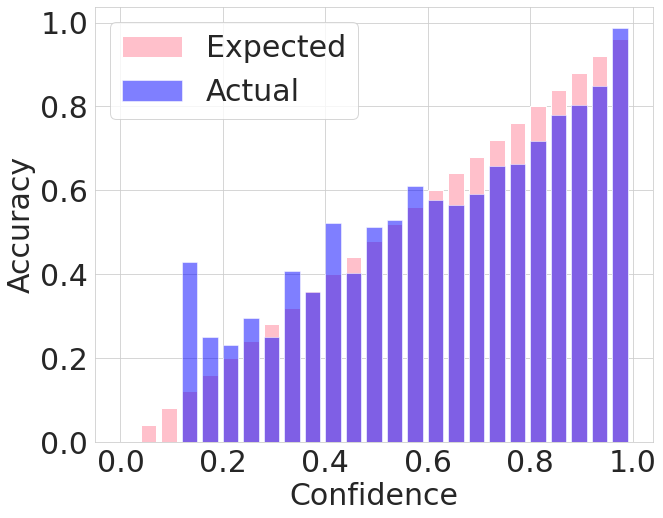

In [71]:
ece = expected_calibration_error(confidences, predictions, labels, num_bins=15)
print (ece)
reliability_plot(confidences, predictions, labels, num_bins=25)

In [72]:
import torch
import torch.nn.functional as F


def entropy(logits):
    p = F.softmax(logits, dim=1)
    logp = F.log_softmax(logits, dim=1)
    plogp = p * logp
    entropy = -torch.sum(plogp, dim=1)
    return entropy


def logsumexp(logits):
    return torch.logsumexp(logits, dim=1, keepdim=False)


def confidence(logits):
    p = F.softmax(logits, dim=1)
    confidence, _ = torch.max(p, dim=1)
    return confidence


def entropy_prob(probs):
    p = probs
    eps = 1e-12
    logp = torch.log(p + eps)
    plogp = p * logp
    entropy = -torch.sum(plogp, dim=1)
    return entropy


def mutual_information_prob(probs):
    mean_output = torch.mean(probs, dim=0)
    predictive_entropy = entropy_prob(mean_output)

    # Computing expectation of entropies
    p = probs
    eps = 1e-12
    logp = torch.log(p + eps)
    plogp = p * logp
    exp_entropies = torch.mean(-torch.sum(plogp, dim=2), dim=0)

    # Computing mutual information
    mi = predictive_entropy - exp_entropies
    return mi

In [73]:
import torch
import torch.nn.functional as F
from sklearn import metrics


def get_roc_auc(net, test_loader, ood_test_loader, uncertainty, device, confidence=False):
    logits, _ = get_logits_labels(net, test_loader, device)
    ood_logits, _ = get_logits_labels(net, ood_test_loader, device)

    return get_roc_auc_logits(logits, ood_logits, uncertainty, device, confidence=confidence)


def get_roc_auc_logits(logits, ood_logits, uncertainty, device, confidence=False):
    uncertainties = uncertainty(logits)
    ood_uncertainties = uncertainty(ood_logits)

    # In-distribution
    bin_labels = torch.zeros(uncertainties.shape[0]).to(device)
    in_scores = uncertainties

    # OOD
    bin_labels = torch.cat((bin_labels, torch.ones(ood_uncertainties.shape[0]).to(device)))

    if confidence:
        bin_labels = 1 - bin_labels
    ood_scores = ood_uncertainties  # entropy(ood_logits)
    scores = torch.cat((in_scores, ood_scores))

    fpr, tpr, thresholds = metrics.roc_curve(bin_labels.cpu().numpy(), scores.cpu().numpy())
    precision, recall, prc_thresholds = metrics.precision_recall_curve(bin_labels.cpu().numpy(), scores.cpu().numpy())
    auroc = metrics.roc_auc_score(bin_labels.cpu().numpy(), scores.cpu().numpy())
    auprc = metrics.average_precision_score(bin_labels.cpu().numpy(), scores.cpu().numpy())

    return (fpr, tpr, thresholds), (precision, recall, prc_thresholds), auroc, auprc


In [74]:
(_, _, _), (_, _, _), auroc, auprc = get_roc_auc(model, cifar100_test_loader, svhn_test_loader, entropy, device)
print (f"AUROC: {auroc}")
print (f"AUPRC: {auprc}")

AUROC: 0.9362058063153043
AUPRC: 0.9736802933191756


In [75]:
(_, _, _), (_, _, _), auroc, auprc = get_roc_auc(model, cifar100_test_loader, cifar10_test_loader, entropy, device)
print (f"AUROC: {auroc}")
print (f"AUPRC: {auprc}")

AUROC: 0.93662982
AUPRC: 0.9413307921886912


## Experimental things

In [80]:
# Computing the AUROC with the attention head disagreement

import torch
import math
import torch.nn.functional as F
from sklearn import metrics

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


device = "cuda" if torch.cuda.is_available() else "cpu"

def recursive_weight_mult(aug_att_mat):
    # print (aug_att_mat.size(0))
    for n in range(1, aug_att_mat.size(0)):
        aug_att_mat[n] = torch.matmul(aug_att_mat[n], aug_att_mat[n-1])
    return aug_att_mat



def predictive_entropy_patch(joint_attention):
    """
    Compute predictive entropy for joint attention maps
    """
    joint_attention = joint_attention.permute(0,2,1,3)
    mean_attention = torch.mean(joint_attention, dim=2)
    p = mean_attention
    eps = 1e-20
    logp = torch.log(p + eps)
    plogp = p * logp
    pe = - torch.sum(plogp, dim=2)
    return pe


def mutual_info_patch(joint_attention):
    """
    Compute mutual information for joint attention maps
    """
    pe = predictive_entropy_patch(joint_attention)
    joint_attention = joint_attention.permute(0,2,1,3)
    p = joint_attention
    eps = 1e-20
    logp = torch.log(p + eps)
    plogp = p * logp
    exp_entropy = torch.mean(- torch.sum(plogp, dim=-1), dim=-1)
    mi = pe - exp_entropy
    return mi
    
    

def entropy_spread(attention_map):
    p = attention_map
    eps = 1e-20
    logp = torch.log(p + eps)
    plogp = p * logp
    ent = - torch.sum(plogp, dim=-1)
    return torch.mean(ent, dim=1)
    
# The list contains attention maps across the depth of the transformer
# Each attention map tensor contains the output for all heads.
mis = []
pes = []
ents = []
softmax_entropies = []
model.eval()
for data, label in tqdm(cifar10_test_loader):
    data = data.to(device)
    label = label.to(device)
    
    with torch.no_grad():
        logit, att_weight = model(data)
    att_weight = torch.stack(att_weight)
    att_weight = recursive_weight_mult(att_weight)[-1]
    #     att_weight = att_weight[-1]
    att_weights = att_weight.mean(dim=1)
    ent = entropy_spread(att_weights)
    softmax_entropies.append(entropy(logit))
    # mi = torch.mean(mutual_info_patch(att_weight), dim=-1)
    mi = mutual_info_patch(att_weight)
    pe = predictive_entropy_patch(att_weight)
    ents.append(ent)
    mis.append(mi)
    pes.append(pe)
ents_cifar10 = torch.cat(ents, dim=0)
mi_cifar10 = torch.cat(mis, dim=0)
pe_cifar10 = torch.cat(pes, dim=0)
softmax_entropies_cifar10 = torch.cat(softmax_entropies, dim=0)

100%|██████████| 157/157 [00:11<00:00, 13.89it/s]


In [81]:
mi_cifar10.shape

torch.Size([10000, 197])

In [82]:
mis = []
pes = []
ents = []
softmax_entropies = []
model.eval()
for data, label in tqdm(svhn_test_loader):
    data = data.to(device)
    label = label.to(device)
    
    with torch.no_grad():
        logit, att_weight = model(data)
    att_weight = torch.stack(att_weight)
    # att_weight = recursive_weight_mult(att_weight)[-1]
    att_weight = att_weight[-1]
    att_weights = att_weight.mean(dim=1)
    ent = entropy_spread(att_weights)
    softmax_entropies.append(entropy(logit))
    # mi = torch.mean(mutual_info_patch(att_weight), dim=-1)
    mi = mutual_info_patch(att_weight)
    pe = predictive_entropy_patch(att_weight)
    ents.append(ent)
    mis.append(mi)
    pes.append(pe)
ents_svhn = torch.cat(ents, dim=0)
mi_svhn = torch.cat(mis, dim=0)
pe_svhn = torch.cat(pes, dim=0)
softmax_entropies_svhn = torch.cat(softmax_entropies, dim=0)

100%|██████████| 407/407 [00:24<00:00, 16.52it/s]


In [83]:
mis = []
pes = []
ents = []
softmax_entropies = []
model.eval()
for data, label in tqdm(cifar100_test_loader):
    data = data.to(device)
    label = label.to(device)
    
    with torch.no_grad():
        logit, att_weight = model(data)
    att_weight = torch.stack(att_weight)
    # att_weight = recursive_weight_mult(att_weight)[-1]
    att_weight = att_weight[-1]
    att_weights = att_weight.mean(dim=1)
    ent = entropy_spread(att_weights)
    softmax_entropies.append(entropy(logit))
    # mi = torch.mean(mutual_info_patch(att_weight), dim=-1)
    mi = mutual_info_patch(att_weight)
    pe = predictive_entropy_patch(att_weight)
    ents.append(ent)
    mis.append(mi)
    pes.append(pe)
ents_cifar100 = torch.cat(ents, dim=0)
mi_cifar100 = torch.cat(mis, dim=0)
pe_cifar100 = torch.cat(pes, dim=0)
softmax_entropies_cifar100 = torch.cat(softmax_entropies, dim=0)

100%|██████████| 157/157 [00:10<00:00, 15.69it/s]


In [38]:
print (softmax_entropies_cifar10.shape)
print (softmax_entropies_svhn.shape)
print (softmax_entropies_cifar100.shape)

torch.Size([10000])
torch.Size([26032])
torch.Size([10000])


In [39]:
print (ents_cifar10.shape)
print (ents_svhn.shape)

torch.Size([10000])
torch.Size([26032])


In [40]:
print (mi_cifar10.shape)
print (mi_svhn.shape)

torch.Size([10000, 197])
torch.Size([26032, 197])


In [46]:
mi_cifar10_flattened = torch.flatten(mi_cifar10)
mi_svhn_flattened = torch.flatten(mi_svhn)
mi_cifar100_flattened = torch.flatten(mi_cifar100)
mi_cifar10_mean = torch.mean(mi_cifar10, dim=1)
mi_svhn_mean = torch.mean(mi_svhn, dim=1)
mi_cifar100_mean = torch.mean(mi_cifar100, dim=1)


pe_cifar10_flattened = torch.flatten(pe_cifar10)
pe_svhn_flattened = torch.flatten(pe_svhn)
pe_cifar100_flattened = torch.flatten(pe_cifar100)
pe_cifar10_mean = torch.mean(pe_cifar10, dim=1)
pe_svhn_mean = torch.mean(pe_svhn, dim=1)
pe_cifar100_mean = torch.mean(pe_cifar100, dim=1)

print (mi_cifar10_mean.shape)
print (mi_svhn_mean.shape)

torch.Size([10000])
torch.Size([26032])


In [42]:
print (softmax_entropies_cifar10.shape)
print (softmax_entropies_svhn.shape)

torch.Size([10000])
torch.Size([26032])


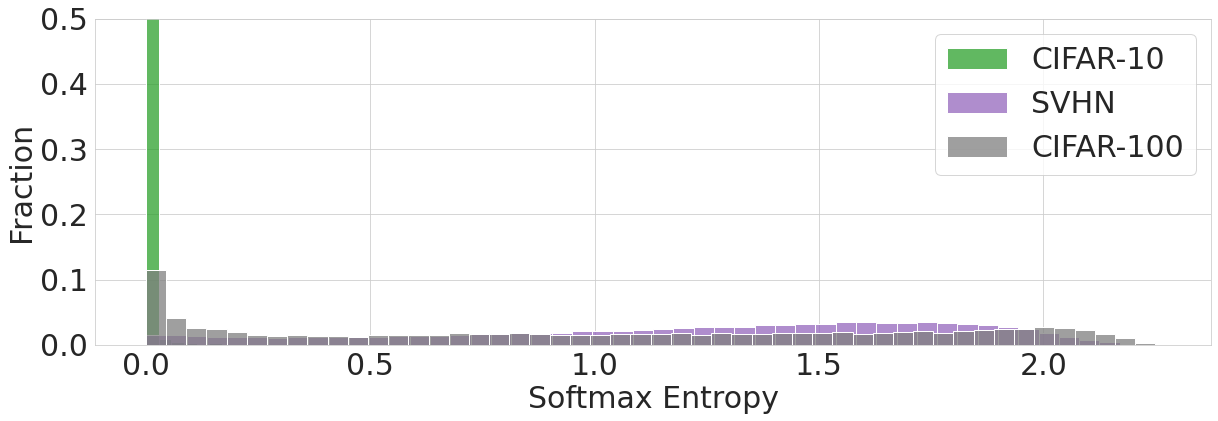

In [43]:
import matplotlib.pyplot as plt
import seaborn as sb

clrs = ['#1f77b4','#ff7f0e', '#2ca02c','#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22','#17becf']

sb.set_style('whitegrid')
plt.rcParams["figure.figsize"] = (20, 6)
plt.rcParams["legend.loc"] = 'upper right'

sb.histplot(softmax_entropies_cifar10.cpu().numpy(), color=clrs[2], 
            stat='probability', kde=False, bins=50, line_kws = {'linewidth': 8}, label='CIFAR-10')
sb.histplot(softmax_entropies_svhn.cpu().numpy(), color=clrs[4], 
            stat='probability', kde=False, bins=50, line_kws = {'linewidth': 8}, label='SVHN')
sb.histplot(softmax_entropies_cifar100.cpu().numpy(), color=clrs[7],
            stat="probability", kde=False, bins=50, line_kws = {'linewidth': 8}, label="CIFAR-100")

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylim(0, 0.5)
plt.xlabel('Softmax Entropy', fontsize=30)
plt.ylabel('Fraction', fontsize=30)
plt.legend(fontsize=30)
plt.savefig('transformer_softmax_entropy.pdf', bbox_inches='tight')
plt.savefig('transformer_softmax_entropy.png', bbox_inches='tight')

In [44]:
# In-distribution
bin_labels = torch.zeros(softmax_entropies_cifar10.shape[0]).to(device)
in_scores = softmax_entropies_cifar10

# OOD
bin_labels = torch.cat((bin_labels, torch.ones(softmax_entropies_svhn.shape[0]).to(device)))
ood_scores = softmax_entropies_svhn  # entropy(ood_logits)
scores = torch.cat((in_scores, ood_scores))

fpr, tpr, thresholds = metrics.roc_curve(bin_labels.cpu().numpy(), scores.cpu().numpy())
precision, recall, prc_thresholds = metrics.precision_recall_curve(bin_labels.cpu().numpy(), scores.cpu().numpy())
auroc = metrics.roc_auc_score(bin_labels.cpu().numpy(), scores.cpu().numpy())
auprc = metrics.average_precision_score(bin_labels.cpu().numpy(), scores.cpu().numpy())

print (auroc)
print (auprc)

0.9964187692071297
0.9985314189173773


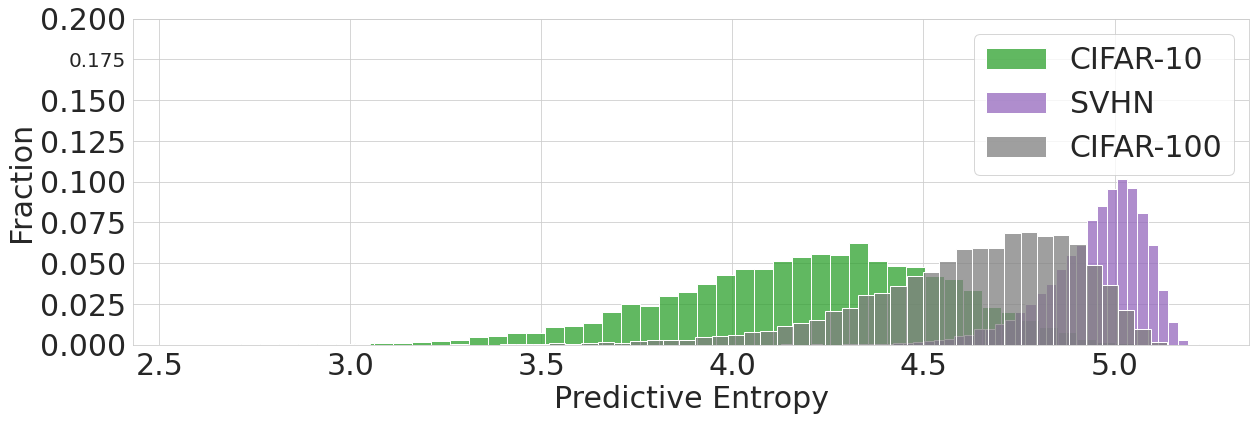

In [47]:
import matplotlib.pyplot as plt
import seaborn as sb

clrs = ['#1f77b4','#ff7f0e', '#2ca02c','#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22','#17becf']

sb.set_style('whitegrid')
plt.rcParams["figure.figsize"] = (20, 6)
plt.rcParams["legend.loc"] = 'upper right'

sb.histplot(pe_cifar10_mean.cpu().numpy(), color=clrs[2], 
            stat='probability', kde=False, bins=50, line_kws = {'linewidth': 8}, label='CIFAR-10')
sb.histplot(pe_svhn_mean.cpu().numpy(), color=clrs[4], 
            stat='probability', kde=False, bins=50, line_kws = {'linewidth': 8}, label='SVHN')
sb.histplot(pe_cifar100_mean.cpu().numpy(), color=clrs[7],
            stat='probability', kde=False, bins=50, line_kws = {'linewidth': 8}, label="CIFAR-100")

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylim(0, 0.2)
plt.xlabel('Predictive Entropy', fontsize=30)
plt.ylabel('Fraction', fontsize=30)
plt.legend(fontsize=30)
plt.savefig('transformer_predictive_entropy.pdf', bbox_inches='tight')
plt.savefig('transformer_predictive_entropy.png', bbox_inches='tight')

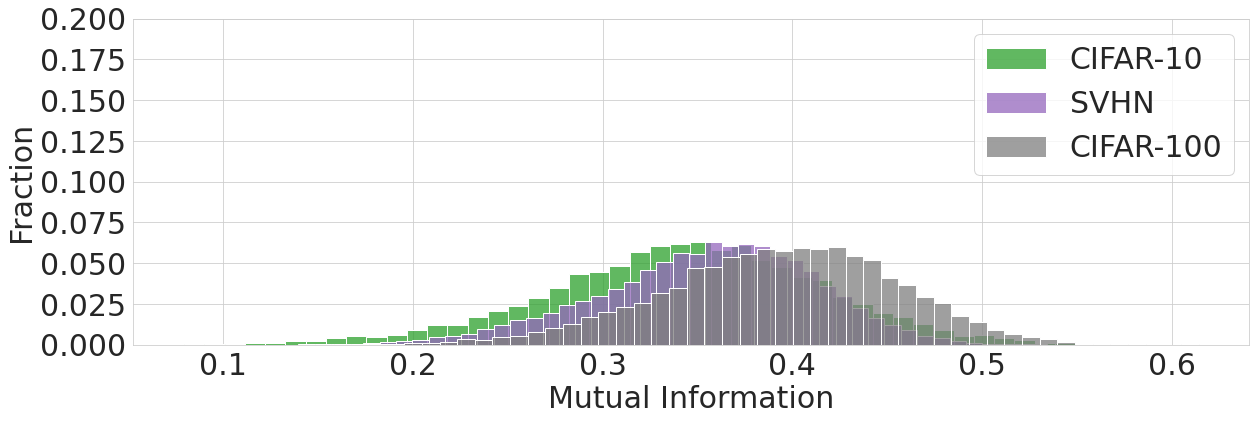

In [49]:
import matplotlib.pyplot as plt
import seaborn as sb

clrs = ['#1f77b4','#ff7f0e', '#2ca02c','#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22','#17becf']

sb.set_style('whitegrid')
plt.rcParams["figure.figsize"] = (20, 6)
plt.rcParams["legend.loc"] = 'upper right'

sb.histplot(mi_cifar10_mean.cpu().numpy(), color=clrs[2], 
            stat='probability', kde=False, bins=50, line_kws = {'linewidth': 8}, label='CIFAR-10')
sb.histplot(mi_svhn_mean.cpu().numpy(), color=clrs[4], 
            stat='probability', kde=False, bins=50, line_kws = {'linewidth': 8}, label='SVHN')
sb.histplot(mi_cifar100_mean.cpu().numpy(), color=clrs[7],
            stat='probability', kde=False, bins=50, line_kws = {'linewidth': 8}, label="CIFAR-100")

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylim(0, 0.2)
plt.xlabel('Mutual Information', fontsize=30)
plt.ylabel('Fraction', fontsize=30)
plt.legend(fontsize=30)
plt.savefig('transformer_mutual_information.pdf', bbox_inches='tight')
plt.savefig('transformer_mutual_information.png', bbox_inches='tight')

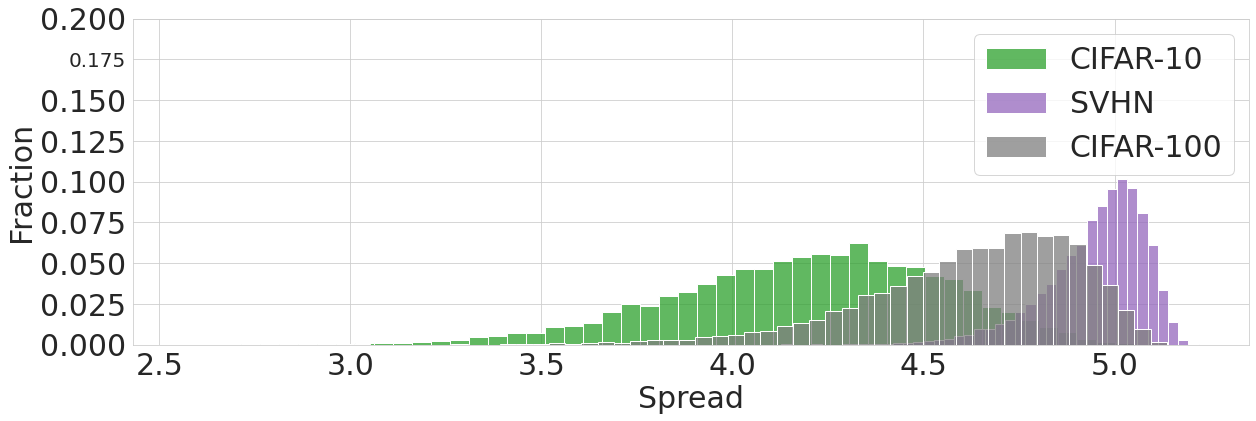

In [50]:
import matplotlib.pyplot as plt
import seaborn as sb

clrs = ['#1f77b4','#ff7f0e', '#2ca02c','#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22','#17becf']

sb.set_style('whitegrid')
plt.rcParams["figure.figsize"] = (20, 6)
plt.rcParams["legend.loc"] = 'upper right'

sb.histplot(ents_cifar10.cpu().numpy(), color=clrs[2], 
            stat='probability', kde=False, bins=50, line_kws = {'linewidth': 8}, label='CIFAR-10')
sb.histplot(ents_svhn.cpu().numpy(), color=clrs[4], 
            stat='probability', kde=False, bins=50, line_kws = {'linewidth': 8}, label='SVHN')
sb.histplot(ents_cifar100.cpu().numpy(), color=clrs[7],
            stat='probability', kde=False, bins=50, line_kws = {'linewidth': 8}, label='CIFAR-100')

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylim(0, 0.2)
plt.xlabel('Spread', fontsize=30)
plt.ylabel('Fraction', fontsize=30)
plt.legend(fontsize=30)
plt.savefig('transformer_spread.pdf', bbox_inches='tight')
plt.savefig('transformer_spread.png', bbox_inches='tight')